In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import os, h5py
import tensorflow as tf

from tqdm import tqdm
from numba import njit

from msfm.utils.io import read_yaml

Redshift dependence of the bias parameter

In [2]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

z0 = 0.7
eta_fid = 0.5
b_fid = 1.5

# Metacal tomo bin
tomo_range = range(1, 5)
component = "g1"

### load redshift bins

[Text(0.5, 0, 'z'), Text(0, 0.5, 'n(z)')]

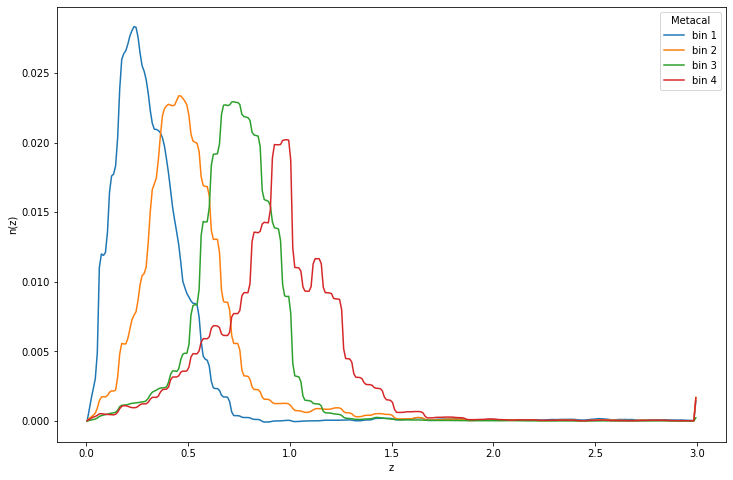

In [3]:
fig, ax = plt.subplots(figsize=(12,8))

z_tomo = []
nz_tomo = []
for tomo in tomo_range:
    z_bin_dir = f"../../data/redshift_distributions/desy3_nz_metacal_bin{tomo}.txt"
    redshift_dist = np.loadtxt(z_bin_dir)

    z = redshift_dist[:,0]
    nz = redshift_dist[:,1]

    ax.plot(z, nz, label=f"bin {tomo}")

    z_tomo.append(z)
    nz_tomo.append(nz)

ax.legend(title="Metacal")
ax.set(xlabel="z", ylabel="n(z)")

In [4]:
biases = []
for z, nz in zip(z_tomo, nz_tomo):
    f = nz * ((1+z)/(1+z0))**eta_fid

    # This is the integral. There is no multiplication with dz because the nz already include this 
    fz = np.sum(f)/np.sum(nz)

    biases.append(fz*b_fid)

print(biases)

[1.3239316265939447, 1.4137321133389573, 1.515498187511085, 1.595469073271588]


In [5]:
# Original function for orientation

# from https://github.com/tomaszkacprzak/deep_lss/blob/3c145cf8fe04c4e5f952dca984c5ce7e163b8753/deep_lss/lss_astrophysics_model_batch.py#L267
@tf.function()
def get_mean_zevol(z0, eta, nz, zg, n_zbins, batch_size):
    """
    Get redshift evolution of a quantity
    """

    eta_e = tf.reshape(eta, shape=(batch_size, 1, 1))
    zg_e = tf.expand_dims(zg, axis=0)
    f = ((1+zg)/(1+z0))**eta_e
    fz = tf.reduce_sum(nz*f, axis=2)/tf.expand_dims(tf.reduce_sum(nz, axis=1), axis=0)

    return fz
